# Earthquake Detection Workflow using QuakeFlow

## Outline

Here we show an example of the current modules in QuakeFlow

1. Download data using Obpsy:

    [FDSN web service client for ObsPy](https://docs.obspy.org/packages/obspy.clients.fdsn.html#module-obspy.clients.fdsn)
    
2. PhaseNet for P/S phase picking

    Find more details in [PhaseNet github page](https://ai4eps.github.io/PhaseNet/)

3. GaMMA for phase association

    Find more details in [GaMMA github page](https://ai4eps.github.io/GaMMA/)
    
4. HypoSVI for locating earthquakes

    Find more details in [HypoSVI github page](https://github.com/Ulvetanna/HypoSVI)



## 0. Install python (e.g., [miniconda](https://docs.conda.io/en/latest/miniconda.html)) and download packages

In [19]:
%%capture
!git clone https://github.com/AI4EPS/PhaseNet.git
!git clone https://github.com/AI4EPS/GaMMA.git
## TODO: HypoSVI

requirements = """
numpy
scipy
matplotlib
obspy
tensorflow==2.14
tqdm
gmma
pandas
"""
with open('requirements.txt', 'w') as f:
    f.write(requirements)
!pip install -r requirements.txt


## 1. Set configurations

In [2]:
import os
import matplotlib
import matplotlib.pyplot as plt
from glob import glob

matplotlib.use("agg")
%matplotlib inline

region_name = "Hawaii"
dir_name = region_name
if not os.path.exists(dir_name):
    os.mkdir(dir_name)
root_dir = lambda x: os.path.join(dir_name, x)

In [3]:
def set_config(
    region_name,
    config_json,
):

    import json
    import numpy as np
    import obspy

    degree2km = np.pi * 6371 / 180

    config = {}
    if region_name == "Hawaii":
        config["center"] = (-155.32, 19.39)
        config["minlatitude"] = 18.39
        config["maxlatitude"] = 20.39
        config["minlongitude"] = -156.32
        config["maxlongitude"] = -154.32
        config["starttime"] = obspy.UTCDateTime("2024-02-09T20").datetime.strftime("%Y-%m-%dT%H:%M:%S.%f")
        config["endtime"] = obspy.UTCDateTime("2024-02-10T20").datetime.strftime("%Y-%m-%dT%H:%M:%S.%f")
        config["client"] = "IRIS"
        config["networks"] = ["HV", "PT"]
        config["channels"] = "HH*,EH*"


    ## PhaseNet
    config["phasenet"] = {}
    ## GaMMA
    config["gamma"] = {}
    ## HypoDD
    config["hypodd"] = {"MAXEVENT": 1e4}

    with open(config_json, "w") as fp:
        json.dump(config, fp, indent=2)

    print(json.dumps(config, indent=4))

In [4]:
set_config(region_name, root_dir("config.json"))

{
    "center": [
        -155.32,
        19.39
    ],
    "minlatitude": 18.39,
    "maxlatitude": 20.39,
    "minlongitude": -156.32,
    "maxlongitude": -154.32,
    "starttime": "2024-02-09T20:00:00.000000",
    "endtime": "2024-02-10T20:00:00.000000",
    "client": "IRIS",
    "networks": [
        "HV",
        "PT"
    ],
    "channels": "HH*,EH*",
    "phasenet": {},
    "gamma": {},
    "hypodd": {
        "MAXEVENT": 10000.0
    }
}


## 2. Download events of the standard catalog for comparison

In [5]:
def download_events(
    config_json,
    standard_catalog
):

    import json
    from collections import defaultdict
    import matplotlib.pyplot as plt
    import pandas as pd
    from obspy.clients.fdsn import Client

    with open(config_json, "r") as fp:
        config = json.load(fp)

    client = Client("usgs")
    events = client.get_events(
        starttime=config["starttime"],
        endtime=config["endtime"],
        minlongitude=config["minlongitude"],
        maxlongitude=config["maxlongitude"],
        minlatitude=config["minlatitude"],
        maxlatitude=config["maxlatitude"],
    )
    print(f"Number of events: {len(events)}")

    ####### Save catalog ########
    catalog = defaultdict(list)
    for event in events:
        if len(event.magnitudes) > 0:
            catalog["time"].append(event.origins[0].time.datetime.strftime("%Y-%m-%dT%H:%M:%S.%f"))
            catalog["magnitude"].append(event.magnitudes[0].mag)
            catalog["longitude"].append(event.origins[0].longitude)
            catalog["latitude"].append(event.origins[0].latitude)
            catalog["depth_km"].append(event.origins[0].depth/1e3)
    catalog = pd.DataFrame.from_dict(catalog).sort_values(["time"])
    catalog.to_csv(standard_catalog, index=False)

    ####### Plot catalog ########
    plt.figure()
    plt.scatter(catalog["longitude"], catalog["latitude"], c=catalog["depth_km"], s=1.0, cmap="viridis_r")
    plt.colorbar()
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.axis("scaled")
    plt.show()

    plt.figure()
    plt.scatter(pd.to_datetime(catalog["time"]), catalog["magnitude"], s=1.0)
    plt.gcf().autofmt_xdate()
    plt.ylabel("Magnitude")
    plt.title(f"Number of events: {len(events)}")
    plt.show()

Number of events: 125


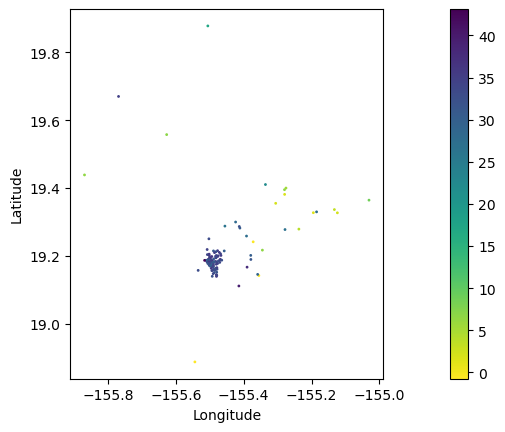

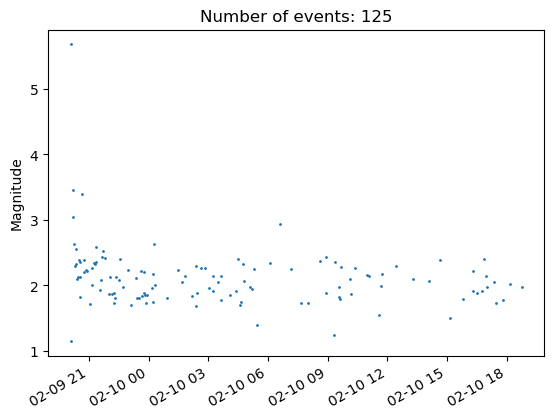

In [6]:
download_events(root_dir("config.json"), root_dir("standard_catalog.csv"))

## 3. Download stations

In [7]:
def download_stations(config_json, station_json, station_pkl):

    import json
    import os
    import pickle
    from collections import defaultdict

    import matplotlib.pyplot as plt
    import obspy
    import pandas as pd
    from obspy.clients.fdsn import Client


    with open(config_json, "r") as fp:
        config = json.load(fp)

    print("Network:", ",".join(config["networks"]))

    ####### Download stations ########
    client = Client(config["client"])
    stations = client.get_stations(
        network=",".join(config["networks"]),
        station="*",
        starttime=config["starttime"],
        endtime=config["endtime"],
        minlongitude=config["minlongitude"],
        maxlongitude=config["maxlongitude"],
        minlatitude=config["minlatitude"],
        maxlatitude=config["maxlatitude"],
        channel=config["channels"],
        level="response",
    )

    print("Number of stations: {}".format(sum([len(x) for x in stations])))

    ####### Save stations ########
    station_locs = defaultdict(dict)
    for network in stations:
        for station in network:
            for chn in station:
                sid = f"{network.code}.{station.code}.{chn.location_code}.{chn.code[:-1]}"
                if sid in station_locs:
                    if chn.code[-1] not in station_locs[sid]["component"]:
                        station_locs[sid]["component"].append(chn.code[-1])
                        station_locs[sid]["response"].append(round(chn.response.instrument_sensitivity.value, 2))
                else:
                    tmp_dict = {
                        "longitude": chn.longitude,
                        "latitude": chn.latitude,
                        "elevation_m": chn.elevation,
                        "component": [
                            chn.code[-1],
                        ],
                        "response": [
                            round(chn.response.instrument_sensitivity.value, 2),
                        ],
                        "unit": chn.response.instrument_sensitivity.input_units.lower(),
                    }
                    station_locs[sid] = tmp_dict

    with open(station_json, "w") as fp:
        json.dump(station_locs, fp, indent=2)

    with open(station_pkl, "wb") as fp:
        pickle.dump(stations, fp)
    
    ######## Plot stations ########
    station_locs = pd.DataFrame.from_dict(station_locs, orient="index")
    plt.figure()
    plt.plot(station_locs["longitude"], station_locs["latitude"], "^", label="Stations")
    plt.axis("scaled")
    plt.legend()
    plt.title(f"Number of stations: {len(station_locs)}")
    plt.show()

Network: HV,PT
Number of stations: 67


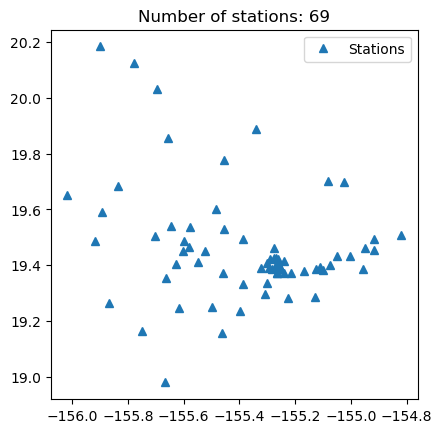

In [8]:
download_stations(root_dir("config.json"), root_dir("stations.json"), root_dir("stations.pkl")) 

## 4. Download waveform data

In [9]:
def download_waveform(config_json, station_pkl, waveform_dir):

    import json
    import os
    import pickle
    import threading
    import time
    import pandas as pd
    import obspy

    lock = threading.Lock()

    with open(config_json, "r") as fp:
        config = json.load(fp)
    with open(station_pkl, "rb") as fp:
        stations = pickle.load(fp)

    if not os.path.exists(waveform_dir):
        os.makedirs(waveform_dir)

    ####### Download data ########
    client = obspy.clients.fdsn.Client(config["client"])
    def download(starttime, endtime):
        starttime = obspy.UTCDateTime(starttime)
        endtime = obspy.UTCDateTime(endtime)
        fname = "{}.mseed".format(starttime.datetime.strftime("%Y-%m-%dT%H:%M:%S"))
        if os.path.exists(os.path.join(waveform_dir, fname)):
            print(f"{fname} exists")
            return
        max_retry = 10
        stream = obspy.Stream()
        print(f"{fname} download starts")
        num_sta = 0
        for network in stations:
            for station in network:
                print(f"********{network.code}.{station.code}********")
                retry = 0
                while retry < max_retry:
                    try:
                        tmp = client.get_waveforms(
                            network.code,
                            station.code,
                            "*",
                            config["channels"],
                            starttime,
                            endtime,
                        )
                        stream += tmp
                        num_sta += len(tmp)
                        break
                    except Exception as err:
                        print("Error {}.{}: {}".format(network.code, station.code, err))
                        message = "No data available for request."
                        if str(err)[: len(message)] == message:
                            break
                        retry += 1
                        time.sleep(5)
                        continue
                if retry == max_retry:
                    print(f"{fname}: MAX {max_retry} retries reached : {network.code}.{station.code}")

        if len(stream) > 0:
            stream.write(os.path.join(waveform_dir, fname))
            print(f"{fname} download succeeds")
        else:
            print(f"{fname} empty data")
        lock.acquire()
        lock.release()

    threads = []
    MAX_THREADS = 3
    starttime = pd.to_datetime(config["starttime"])
    endtime = pd.to_datetime(config["endtime"])
    deltatime = pd.Timedelta("1H")
    starttime_list = pd.date_range(start=starttime, end=endtime, freq=deltatime, inclusive="left")
    endtime_list = starttime_list + deltatime
    for ii, (s, e) in enumerate(zip(starttime_list, endtime_list)):
        t = threading.Thread(target=download, args=(s.to_pydatetime(), e.to_pydatetime()))
        t.start()
        time.sleep(1)
        threads.append(t)
        if ii % MAX_THREADS == MAX_THREADS - 1:
            for t in threads:
                t.join()
            threads = []
    for t in threads:
        t.join()


In [10]:
%%capture
download_waveform(root_dir("config.json"), root_dir("stations.pkl"), root_dir("waveforms"))

- If downloading is too slow, you can also download the demo data from AI4EPS huggingface datasets at [https://huggingface.co/datasets/AI4EPS/quakeflow_demo/tree/main/mseed/Hawaii](https://huggingface.co/datasets/AI4EPS/quakeflow_demo/tree/main/mseed/Hawaii)


## 5. Run PhaseNet to pick P/S picks

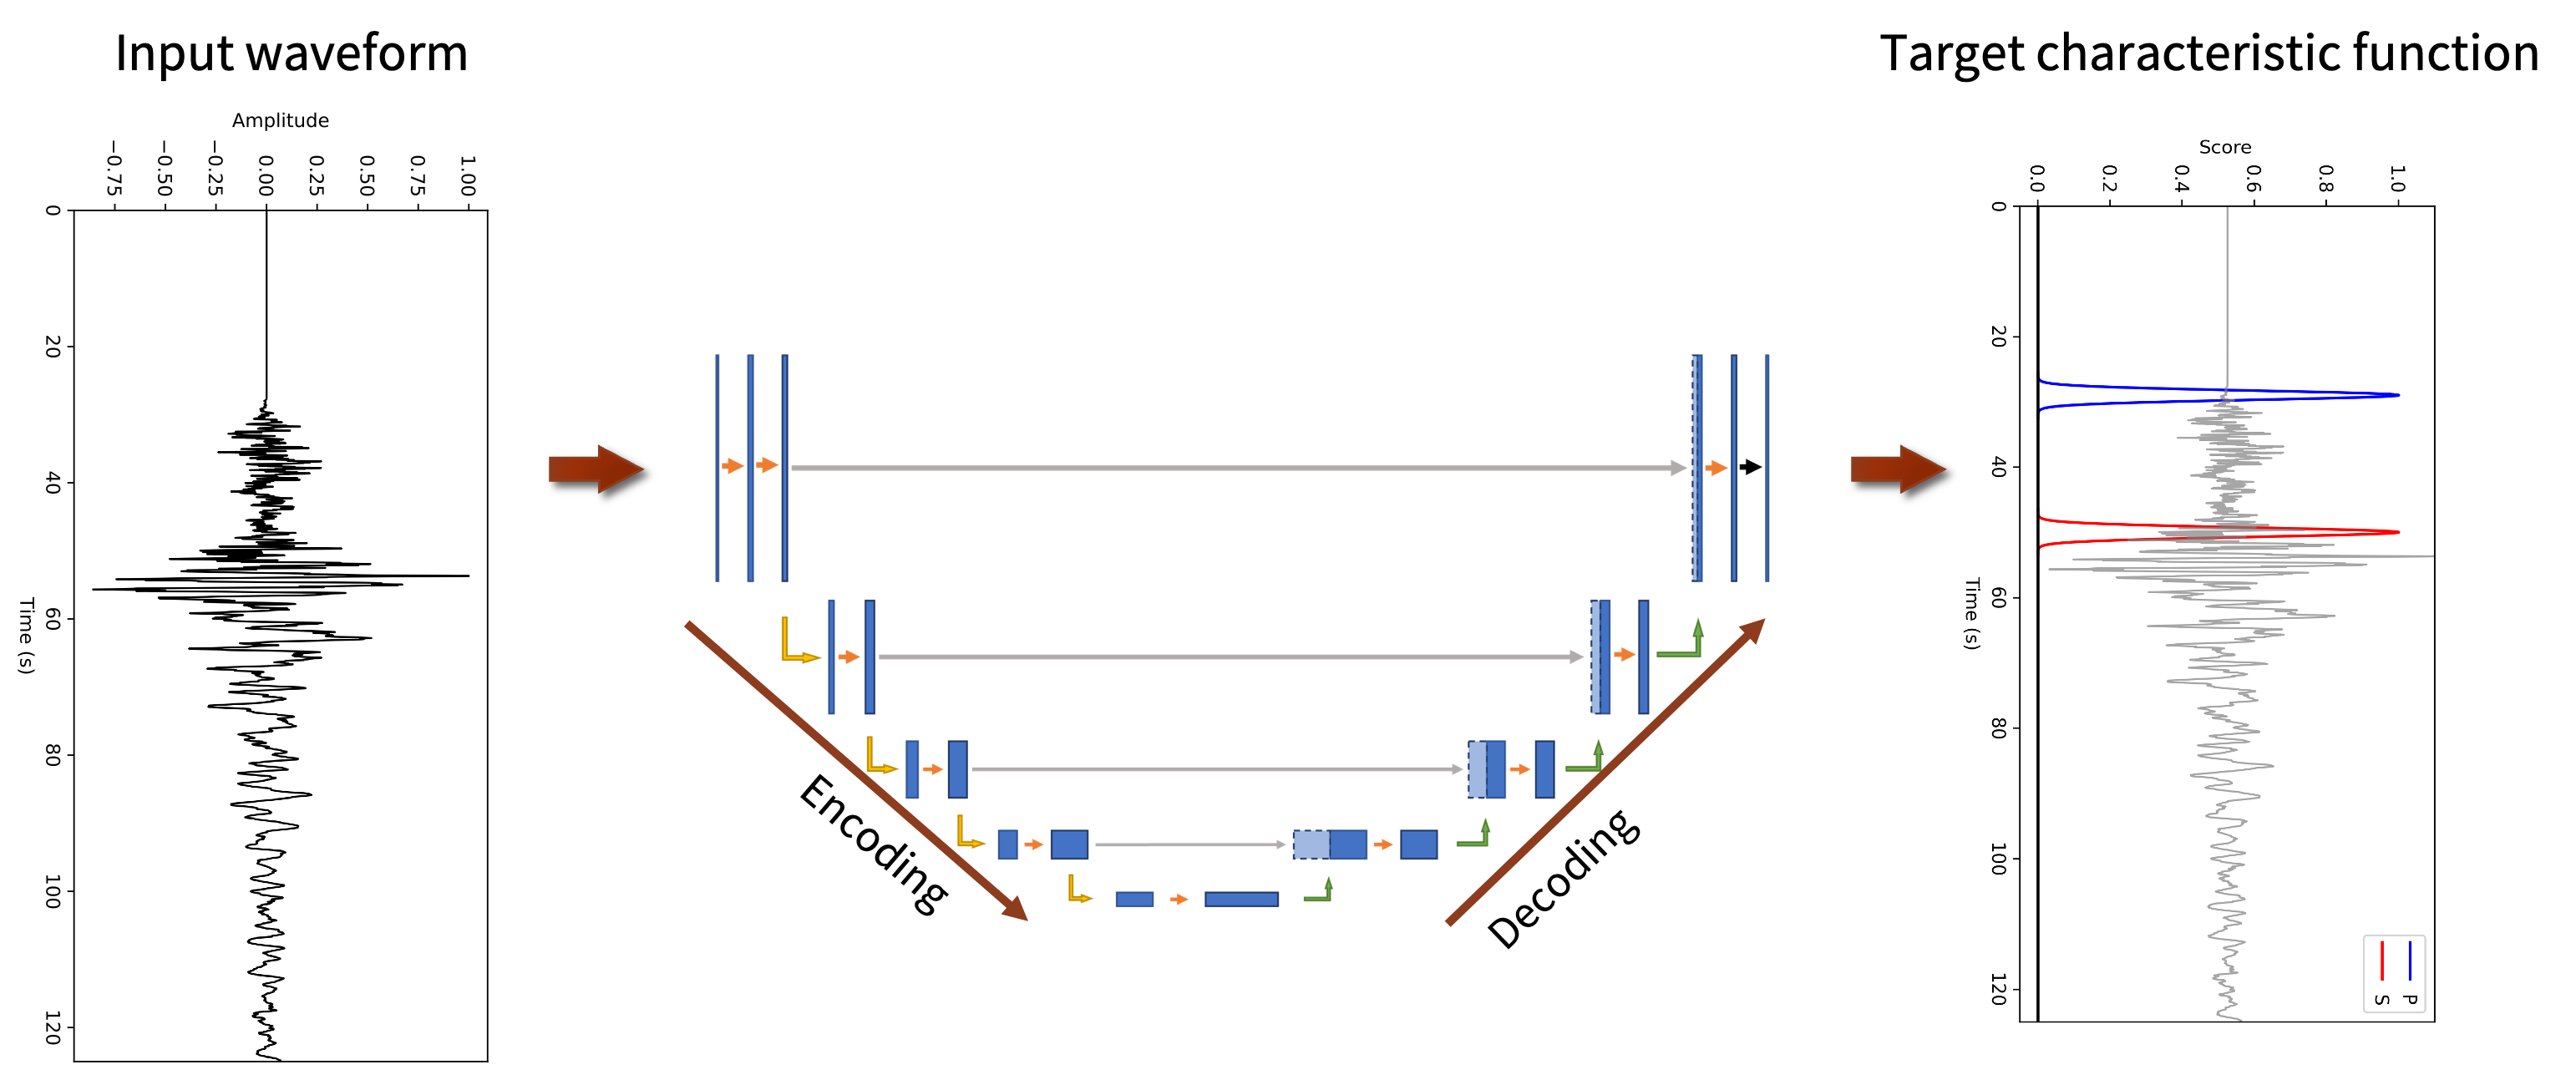

In [14]:
mseeds = glob(f"{root_dir('waveforms')}/*.mseed")
with open(root_dir('fname.csv'), "w") as fp:
    fp.write("fname\n")
    fp.write("\n".join(mseeds))

command = f"python PhaseNet/phasenet/predict.py --model=PhaseNet/model/190703-214543 --data_list={root_dir('fname.csv')} --stations={root_dir('stations.json')} --result_dir={root_dir('phasenet')} --format=mseed_array --amplitude"# --upload_waveform"
print(command)
os.system(f"{command} > phasenet.log")

python PhaseNet/phasenet/predict.py --model=PhaseNet/model/190703-214543 --data_list=Hawaii/fname.csv --stations=Hawaii/stations.json --result_dir=Hawaii/phasenet --format=mseed_array --amplitude


2024-04-22 00:00:54.615749: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 00:00:54.615778: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 00:00:54.616741: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-22 00:00:54.621153: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 00:00:55.155409: W tensorflow/compiler/tf2

## 6. Run GaMMA to associate P/S picks

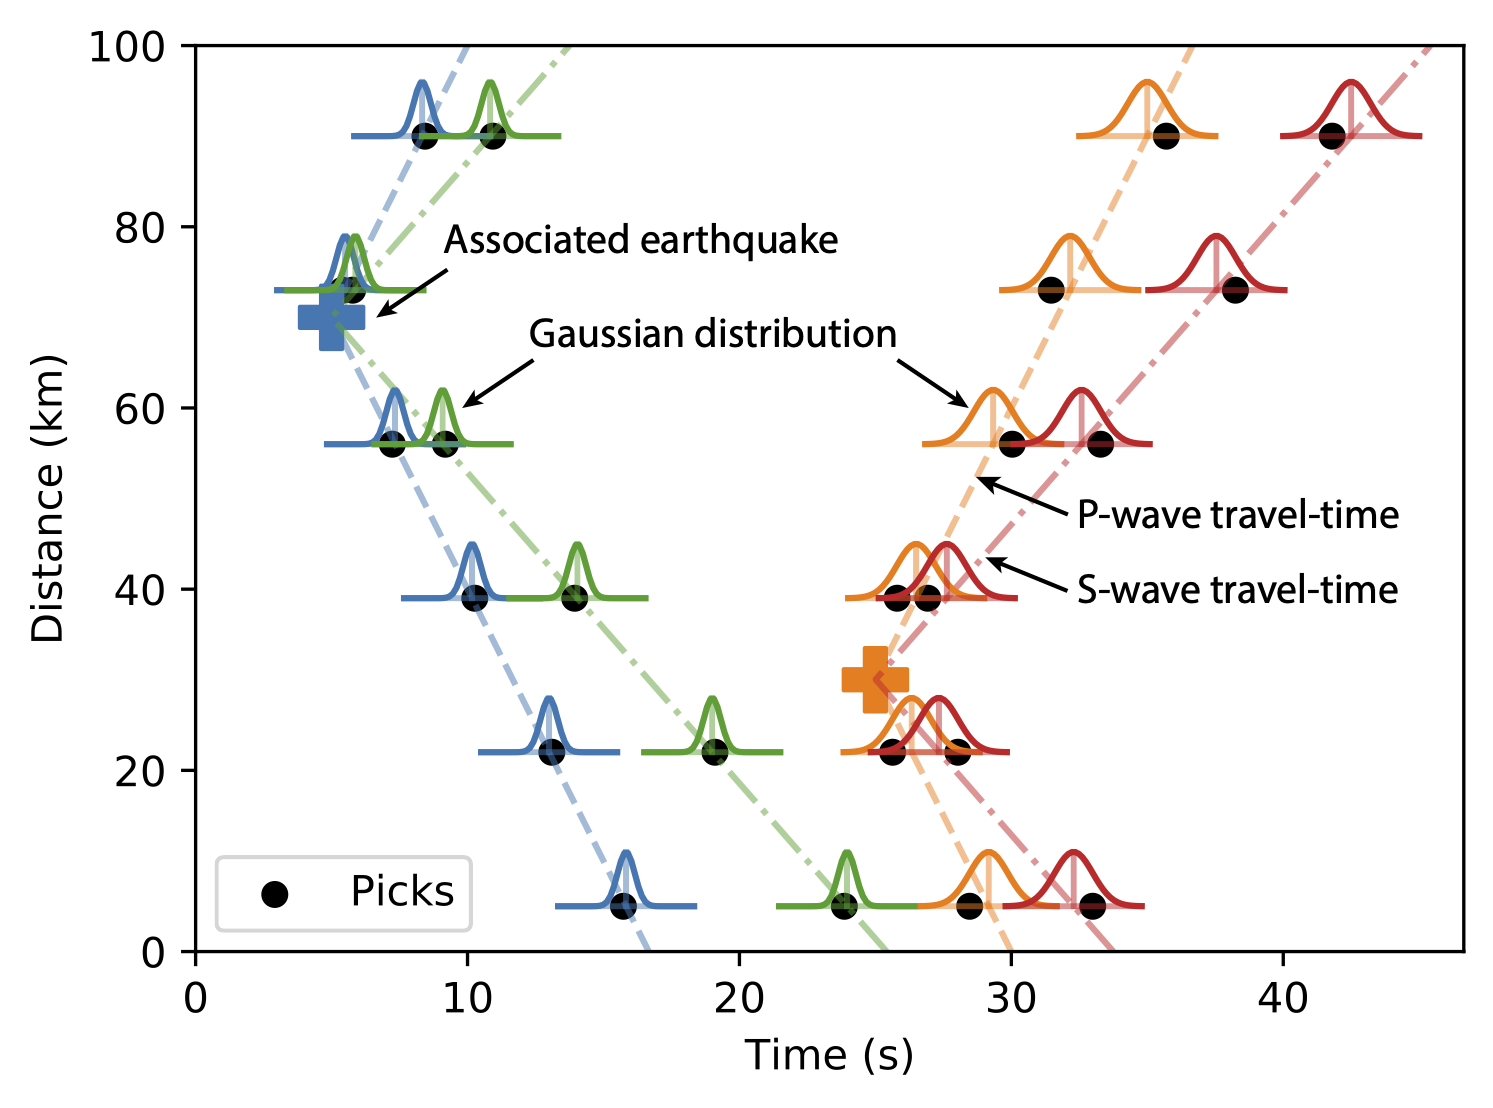

In [12]:
def run_gamma(
    config_json,
    pick_csv,
    station_json,
    gamma_catalog_csv,
    gamma_pick_csv,
):

    import json
    import numpy as np
    import pandas as pd
    from gamma.utils import association
    from pyproj import Proj

    ## read config
    with open(config_json, "r") as fp:
        config = json.load(fp)

    ## read picks
    picks = pd.read_csv(pick_csv, parse_dates=["phase_time"])
    picks["id"] = picks["station_id"]
    picks["timestamp"] = picks["phase_time"]
    picks["amp"] = picks["phase_amp"]
    picks["type"] = picks["phase_type"].str.lower()
    picks["prob"] = picks["phase_score"]

    ## read stations
    with open(station_json, "r") as fp:
        stations = json.load(fp)
    stations = pd.DataFrame.from_dict(stations, orient="index")
    stations["id"] = stations.index
    proj = Proj(f"+proj=sterea +lon_0={config['center'][0]} +lat_0={config['center'][1]} +units=km")
    stations[["x(km)", "y(km)"]] = stations.apply(
        lambda x: pd.Series(proj(longitude=x.longitude, latitude=x.latitude)), axis=1
    )
    stations["z(km)"] = stations["elevation_m"].apply(lambda x: -x / 1e3)

    ## setting GMMA configs
    config["use_dbscan"] = True
    config["use_amplitude"] = True
    config["method"] = "BGMM"
    if config["method"] == "BGMM":  ## BayesianGaussianMixture
        config["oversample_factor"] = 5
    if config["method"] == "GMM":  ## GaussianMixture
        config["oversample_factor"] = 1

    # Earthquake location
    config["vel"] = {"p": 6.0, "s": 6.0 / 1.73}
    config["dims"] = ["x(km)", "y(km)", "z(km)"]
    config["x(km)"] = proj(
        longitude=[config["minlongitude"], config["maxlongitude"]], latitude=[config["center"][1]] * 2
    )[0]
    config["y(km)"] = proj(
        longitude=[config["center"][0]] * 2, latitude=[config["minlatitude"], config["maxlatitude"]]
    )[1]
    config["z(km)"] = (0, 60)
    config["bfgs_bounds"] = (
        (config["x(km)"][0] - 1, config["x(km)"][1] + 1),  # x
        (config["y(km)"][0] - 1, config["y(km)"][1] + 1),  # y
        (0, config["z(km)"][1] + 1),  # z
        (None, None),  # t
    )

    # DBSCAN
    config["dbscan_eps"] = 10  # second
    config["dbscan_min_samples"] = 3  ## see DBSCAN

    # Filtering
    config["min_picks_per_eq"] = min(10, len(stations) // 2)
    config["min_p_picks_per_eq"] = 0
    config["min_s_picks_per_eq"] = 0
    config["max_sigma11"] = 2.0  # s
    config["max_sigma22"] = 2.0  # m/s
    config["max_sigma12"] = 1.0  # covariance

    # if use amplitude
    if config["use_amplitude"]:
        picks = picks[picks["amp"] != -1]

    # print(config)
    for k, v in config.items():
        print(f"{k}: {v}")

    ## run GMMA association
    event_idx0 = 1
    assignments = []
    events, assignments = association(picks, stations, config, event_idx0, method=config["method"])
    event_idx0 += len(events)

    ## create catalog
    events = pd.DataFrame(events)
    events[["longitude", "latitude"]] = events.apply(
        lambda x: pd.Series(proj(longitude=x["x(km)"], latitude=x["y(km)"], inverse=True)), axis=1
    )
    events["depth_km"] = events["z(km)"]
    events.sort_values(["time"], inplace=True)
    try:
        events.to_csv(gamma_catalog_csv, index=False)
    except:
        os.makedirs(os.path.dirname(gamma_catalog_csv))
        events.to_csv(gamma_catalog_csv, index=False)

    ## add assignment to picks
    assignments = pd.DataFrame(assignments, columns=["pick_index", "event_index", "gamma_score"])
    picks = picks.join(assignments.set_index("pick_index")).fillna(-1).astype({"event_index": int})
    # picks.rename(columns={"id": "station_id", "timestamp": "phase_time", "type": "phase_type", "prob": "phase_score", "amp": "phase_amplitude"}, inplace=True)
    picks.sort_values(["phase_time"], inplace=True)
    try:
        picks.to_csv(gamma_pick_csv, index=False)
    except:
        os.makedirs(os.path.dirname(gamma_catalog_csv))
        events.to_csv(gamma_catalog_csv, index=False)

In [15]:
run_gamma(root_dir("config.json"), root_dir("phasenet/picks.csv"), root_dir("stations.json"), root_dir("gamma/events.csv"), root_dir("gamma/picks.csv"))

center: [-155.32, 19.39]
minlatitude: 18.39
maxlatitude: 20.39
minlongitude: -156.32
maxlongitude: -154.32
starttime: 2024-02-09T20:00:00.000000
endtime: 2024-02-10T20:00:00.000000
client: IRIS
networks: ['HV', 'PT']
channels: HH*,EH*
phasenet: {}
gamma: {}
hypodd: {'MAXEVENT': 10000.0}
use_dbscan: True
use_amplitude: True
method: BGMM
oversample_factor: 5
vel: {'p': 6.0, 's': 3.468208092485549}
dims: ['x(km)', 'y(km)', 'z(km)']
x(km): [-105.04607841013517, 105.04607841013781]
y(km): [-110.69357430625773, 110.70573375706894]
z(km): (0, 60)
bfgs_bounds: ((-106.04607841013517, 106.04607841013781), (-111.69357430625773, 111.70573375706894), (0, 61), (None, None))
dbscan_eps: 10
dbscan_min_samples: 3
min_picks_per_eq: 10
min_p_picks_per_eq: 0
min_s_picks_per_eq: 0
max_sigma11: 2.0
max_sigma22: 2.0
max_sigma12: 1.0


Associating 1300 clusters with 32 CPUs
....................................................................................................................................................................................................................................
Associated 100 events
.......................................................................................................................................................................................
Associated 200 events
......................................................................................................................................................................................................
Associated 300 events.
.....................................................................................................................................................................................
Associated 400 events.
.............................................................................

## 7. Run HypoSVI to locate events

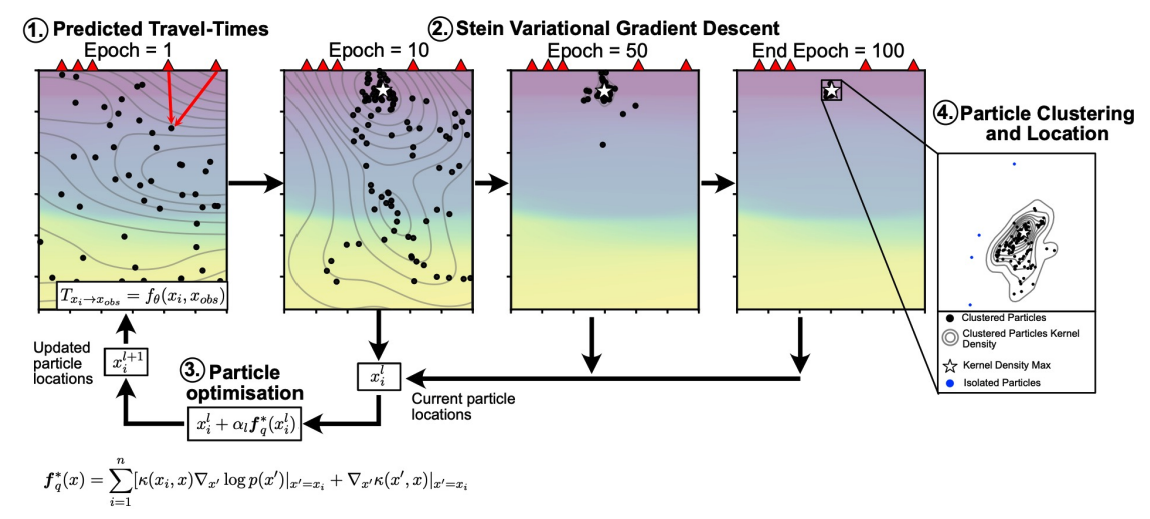

## 8. Plotting results

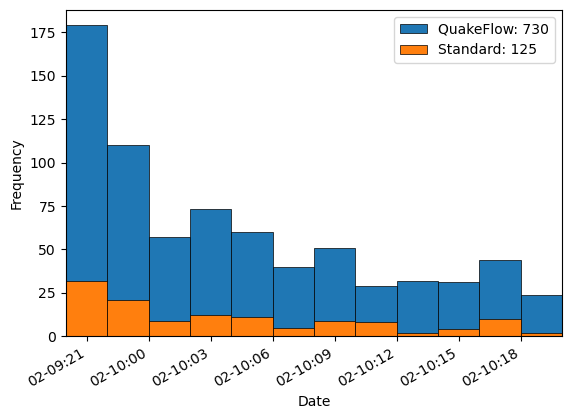

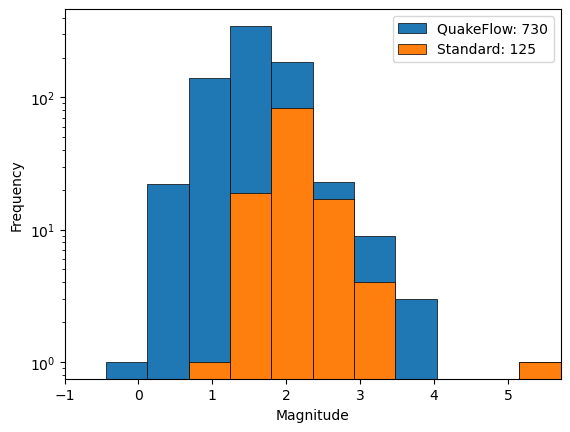

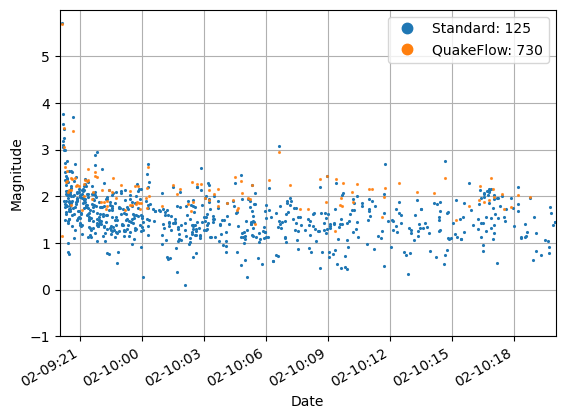

In [16]:
import json
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

result_label="QuakeFlow"
catalog_label="Standard"
event_file = "gamma/events.csv"
picks_file = "gamma/picks.csv"
if not os.path.exists(root_dir(f"figures/")):
    os.makedirs(root_dir(f"figures/"))
figure_dir = lambda x: root_dir(f"figures/{x}")

with open(root_dir("config.json"), "r") as fp:
    config = json.load(fp)
stations = pd.read_json(root_dir("stations.json"), orient="index")
events = pd.read_csv(root_dir(event_file))
events["time"] = events["time"].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%f"))

catalog = pd.read_csv(root_dir("standard_catalog.csv"))
catalog["time"] = catalog["time"].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%f"))

marker_size = 0.1 * 10
bins = min(len(catalog["time"])//50 + 10, 50)

plt.figure()
plt.hist(events["time"], range=(config["starttime"], config["endtime"]), bins=bins, edgecolor="k", alpha=1.0, linewidth=0.5, label=f"{result_label}: {len(events['time'])}")
plt.hist(catalog["time"], range=(config["starttime"], config["endtime"]), bins=bins, edgecolor="k", alpha=1.0, linewidth=0.5, label=f"{catalog_label}: {len(catalog['time'])}")
plt.ylabel("Frequency")
plt.xlabel("Date")
plt.gca().autoscale(enable=True, axis='x', tight=True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.savefig(figure_dir("earthquake_number.png"), bbox_inches="tight", dpi=300)
plt.savefig(figure_dir("earthquake_number.pdf"), bbox_inches="tight")
plt.show()

plt.figure()
xrange = (-1., max(events["magnitude"].max(), catalog["magnitude"].max()))
plt.hist(events["magnitude"], range=xrange, bins=bins, alpha=1.0,  edgecolor="k", linewidth=0.5, label=f"{result_label}: {len(events['magnitude'])}")
plt.hist(catalog["magnitude"], range=xrange, bins=bins, alpha=1.0,  edgecolor="k", linewidth=0.5, label=f"{catalog_label}: {len(catalog['magnitude'])}")
plt.legend()
plt.xlim(xrange)
plt.xlabel("Magnitude")
plt.ylabel("Frequency")
plt.gca().set_yscale('log')
plt.savefig(figure_dir("earthquake_magnitude_frequency.png"), bbox_inches="tight", dpi=300)
plt.savefig(figure_dir("earthquake_magnitude_frequency.pdf"), bbox_inches="tight")
plt.show()

plt.figure()
plt.plot(events["time"], events["magnitude"], '.', markersize=marker_size+1.5, alpha=1.0, rasterized=True)
plt.plot(catalog["time"], catalog["magnitude"], '.', markersize=marker_size+1.5, alpha=0.8, rasterized=True)
plt.xlim(datetime.fromisoformat(config["starttime"]), datetime.fromisoformat(config["endtime"]))
# plt.ylim(top=events["magnitude"].max())
ylim = plt.ylim(bottom=-1)
xlim = plt.xlim()
plt.ylabel("Magnitude")
plt.xlabel("Date")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
plt.gcf().autofmt_xdate()
plt.gca().set_prop_cycle(None)
plt.plot(datetime.fromisoformat(config["starttime"]), -10, '.', markersize=15, alpha=1.0, label=f"{catalog_label}: {len(catalog['magnitude'])}")
plt.plot(datetime.fromisoformat(config["starttime"]), -10, '.', markersize=15, alpha=1.0, label=f"{result_label}: {len(events['magnitude'])}")
plt.legend()
plt.xlim(xlim)
plt.ylim(ylim)
plt.grid()
plt.savefig(root_dir("earthquake_magnitude_time.png"), bbox_inches="tight", dpi=300)
plt.savefig(root_dir("earthquake_magnitude_time.pdf"), bbox_inches="tight", dpi=300)
plt.show();